In [1]:
#| code-summary: "what to show"

SHOW_RATE_VS_ANGLE_LSO = True
SHOW_RATE_VS_ANGLE_MSO = True
SHOW_ITD_ILD = True
SHOW_ADDITIONAL_STATS = False
SHOW_PARAMS = False

In [2]:
#| code-summary: "imports"

%load_ext autoreload
%autoreload 2
import dill
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os import listdir
from os.path import isfile, join
from sorcery import dict_of
import pprint
import IPython
import consts as C
from utils.log import logger
from cochleas.RealisticCochlea import run_hrtf
from analyze import sound_analysis as SA
from utils.custom_sounds import Tone
import logging

2024-08-31 23:13:12,862 [INFO ]  

>>>>> start execution


In [3]:
#| code-summary: "scan results folder"

# scan results folder, default values for figures
# only show results from this "frozen" folder
results_dir = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).parent
files = [
    f
    for f in listdir(results_dir)
    if isfile(join(results_dir, f)) and f.endswith(".pic")
]
files.sort()
selected_files = []

ax = None

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (6, 3)

In [4]:
# | code-summary: "drawing functions"


def draw_rate_vs_angle(data, filename, show_lso=True, show_mso=True):
    angle_to_rate = data["angle_to_rate"]
    name = data["conf"]["model_desc"]["name"]
    sound_key = data["conf"]["sound_key"]
    # cochlea = data["conf"]["cochlea_type"]

    angles = list(angle_to_rate.keys())

    def average_firing_rate(x):
        active_neurons = set(x['senders'])
        return (
            (len(x["times"]) / len(active_neurons)) if len(active_neurons) > 0 else 0
        )

    arr_n_spikes_r_lso = [
        average_firing_rate(x["R"]["LSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_l_lso = [
        average_firing_rate(x["L"]["LSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_r_mso = [
        average_firing_rate(x["R"]["MSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_l_mso = [
        average_firing_rate(x["L"]["MSO"]) for angle, x in angle_to_rate.items()
    ]

    lso = {
        "spikes": [arr_n_spikes_r_lso, arr_n_spikes_l_lso],
        "show": show_lso,
        "label": "lso",
    }
    mso = {
        "spikes": [arr_n_spikes_r_mso, arr_n_spikes_l_mso],
        "show": show_mso,
        "label": "mso",
    }
    data = []
    for i in [lso, mso]:
        if i["show"]:
            data.append(i)
    num_subplots = len(data)
    fig, ax = plt.subplots(num_subplots, figsize=(8, 2 * num_subplots))
    if type(ax) is not np.ndarray:
        ax = [ax]
    for axis, d in zip(ax, data):
        axis.plot(angles, d["spikes"][0], ".-", label=f"right {d["label"]}")
        axis.plot(angles, d["spikes"][1], ".-", label=f"left {d["label"]}")
        axis.set_ylabel("avg spk/sec (Hz)")
        _ = axis.legend()
    # fig.suptitle(f"{name} with {sound_key}")
    plt.suptitle(filename)
    plt.setp([ax], xticks=angles)

    plt.tight_layout()
    plt.show()
    return fig


def draw_ITD_ILD(data, selected):
    previous_level = logger.level
    # itd and ild functions are VERY verbose
    logger.setLevel(logging.WARNING)
    tone: Tone = data["basesound"]
    angle_to_ild = {}
    angle_to_itd = {}
    angles = list(data["angle_to_rate"].keys())
    for angle in angles:
        binaural_sound = run_hrtf(
            tone,
            angle,
            data["conf"]["parameters"]["cochlea"]["realistic"]["subj_number"],
        )
        left = binaural_sound.left
        right = binaural_sound.right
        angle_to_itd[angle] = SA.itd(left, right)
        ild_res, all_freq_diff = SA.ild(left, right, tone.sound)
        angle_to_ild[angle] = ild_res
        # total_diff = np.sum(all_freq_diff)

    fig, ild = plt.subplots(1, sharex=True, figsize=(8, 1.8))
    fig.suptitle(
        f"diff = max(|spectrum(left)|)-max(|spectrum(right)|), freq={tone.frequency}"
    )

    ild.set_ylabel("Power (dB/Hz)", color="r")
    ild.plot(
        angles,
        [angle_to_ild[angle] for angle in angles],
        label="ILD",
        marker=".",
        color="r",
    )
    ild.tick_params(axis="y", labelcolor="r")
    itd = ild.twinx()
    itd.set_ylabel("seconds", color="b")
    itd.plot(
        angles,
        [angle_to_itd[angle] for angle in angles],
        label="ITD",
        marker=".",
        color="b",
    )
    itd.tick_params(axis="y", labelcolor="b")
    _ = fig.legend()

    fig.tight_layout()
    # plt.subplots_adjust(hspace=0.6, wspace=1)
    plt.setp([ild, itd], xticks=angles)
    plt.show()
    logger.setLevel(previous_level)
    return fig


def show_stats(data):
    total_spikes_R_LSO = sum(
        [len(x["R"]["LSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_LSO = sum(
        [len(x["L"]["LSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_R_MSO = sum(
        [len(x["R"]["MSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_MSO = sum(
        [len(x["L"]["MSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    print(
        dict_of(
            total_spikes_R_LSO,
            total_spikes_L_LSO,
            total_spikes_R_MSO,
            total_spikes_L_MSO,
        )
    )


def show_selected_info(selected):
    with open(join(results_dir, selected), "rb") as f:
        res = dill.load(f, ignore=True)
        print(
            f"""\
    name  : {res['conf']['model_desc']['name']}
    sndkey: {res['conf']['sound_key']}
    coctyp: {res['conf']['cochlea_type']}
    params: {pprint.pformat(res['conf']['parameters'], width=10, sort_dicts=False)}"""
        )

Parameters are the same for all these results, the only thing that changes is the frequency of the tone. Here are all parameters, followed by graphs for all frequencies. Sorry that they aren't ordered.

    name  : Inhibitory model, mso iaf_cond_beta
    sndkey: tone_0.333kHz_110dB
    coctyp: realistic
    params: {'key': 'higherMSOexc',
 'cochlea': {'realistic': {'subj_number': 1,
                           'noise_factor': 0.2,
                           'refractory_period': 1},
             'ppg': {}},
 'n_ANFs': 35000,
 'SBCs2MSOs': 5,
 'SBCs2LSOs': 5,
 'n_SBCs': 8750,
 'n_GBCs': 1750,
 'n_MSOs': 1750,
 'n_LSOs': 1750,
 'n_inhMSOs': 1750,
 'V_m': -70,
 'V_reset': -70,
 'C_m_sbc': 1,
 'C_m_gcb': 1,
 'cap_nuclei': 1,
 'C_mso': 1,
 'CONFIG': {'STORE_POPS': {'ANF',
                           'GBC',
                           'LNTBC',
                           'LSO',
                           'MNTBC',
                           'MSO',
                           'SBC'},
            'NEST_KERNEL_PARAMS': {'resolution': 0.1,
                                   'rng_seed': 42,
                                   'total_num_virtual_procs': 16}},
 'DELAYS': {'DELTA_IPSI': 0.2,
            'D

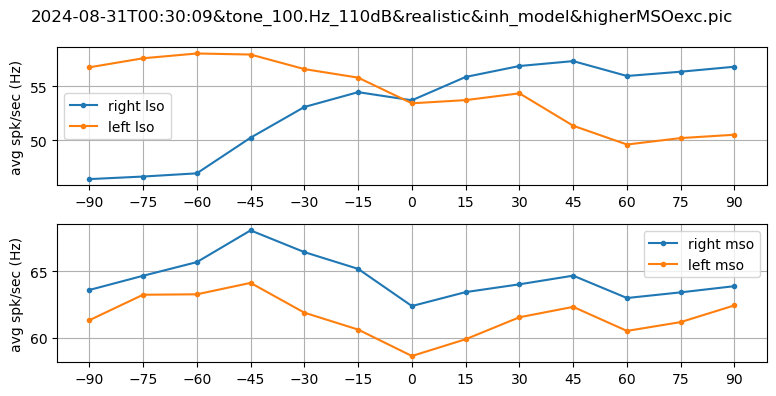

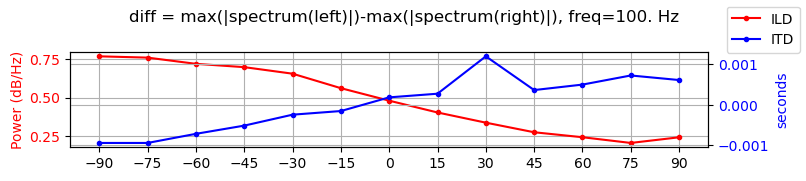

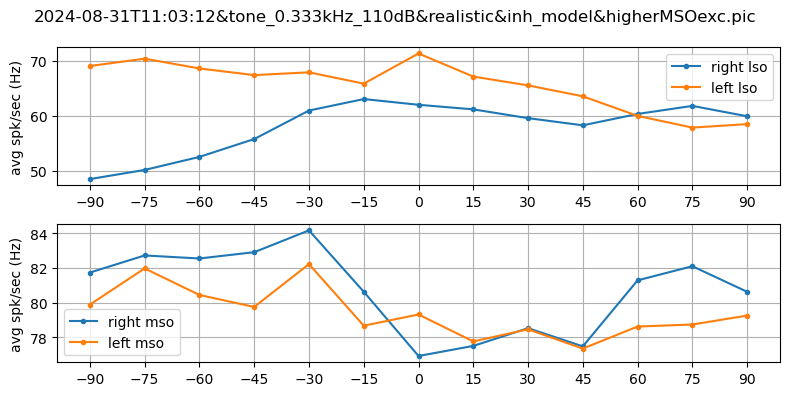

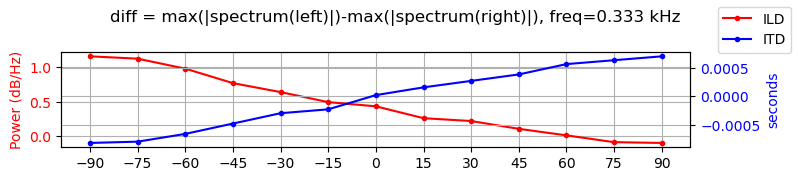

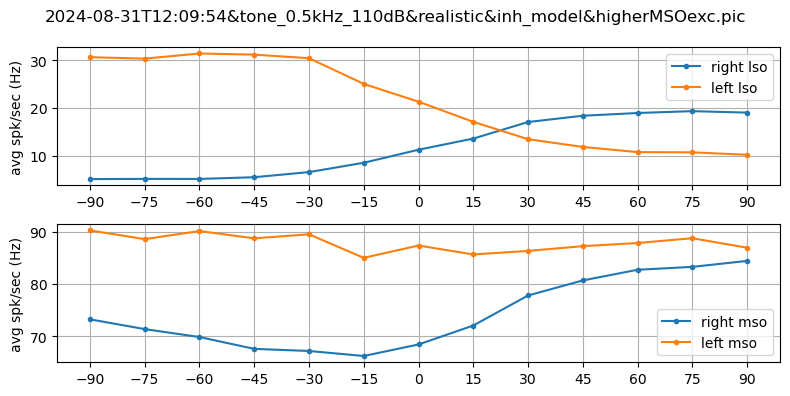

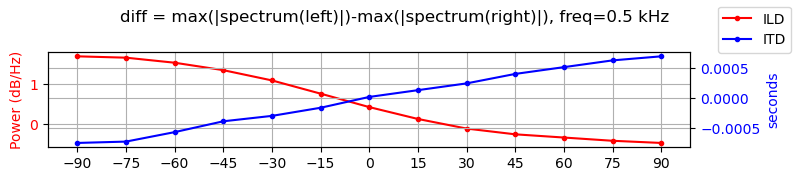

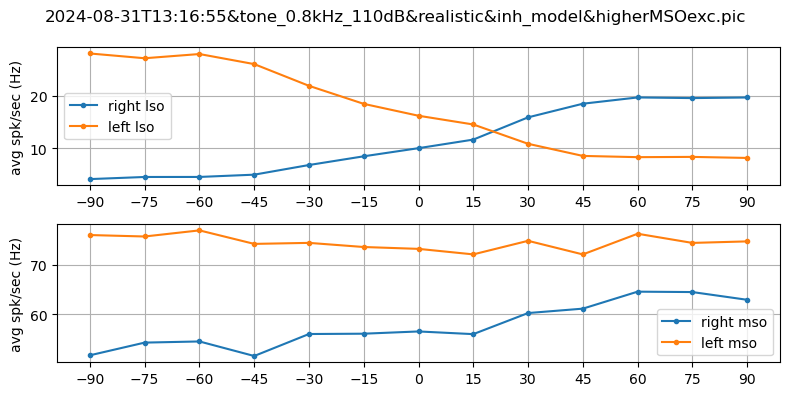

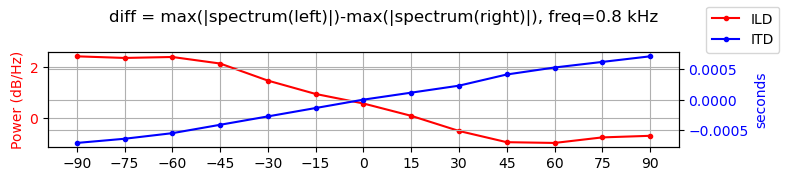

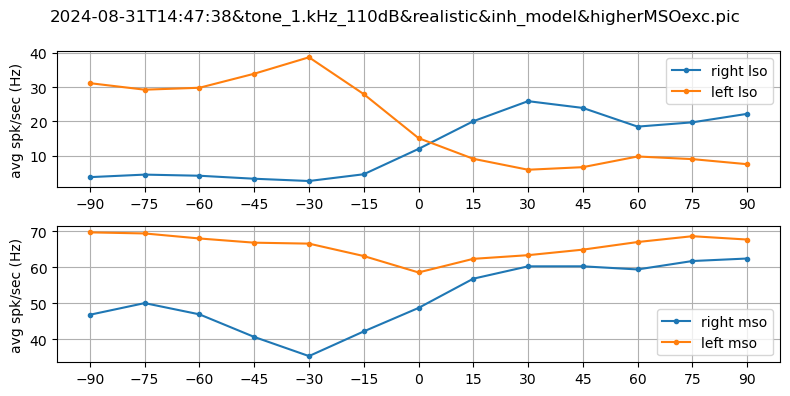

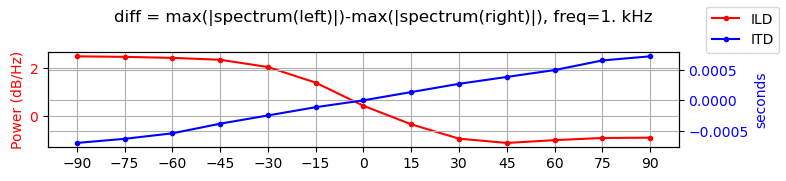

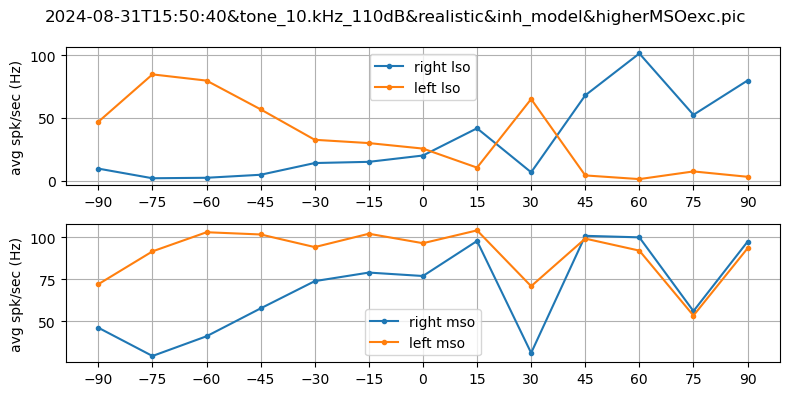

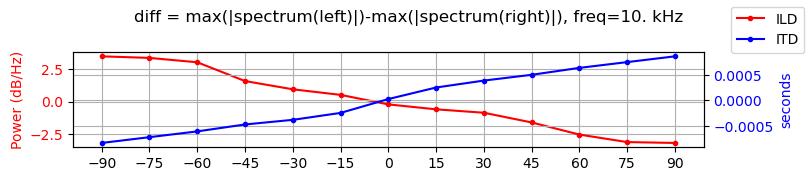

In [5]:
# | code-summary: "draw results"
with open(join(results_dir,files[1]), 'rb') as f:
    res = dill.load(f, ignore=True)
    show_selected_info(files[1])
for selected in files:
    with open(join(results_dir, selected), "rb") as f:
        res = dill.load(f, ignore=True)
        if SHOW_RATE_VS_ANGLE_LSO or SHOW_RATE_VS_ANGLE_MSO:
            draw_rate_vs_angle(res, selected, SHOW_RATE_VS_ANGLE_LSO, SHOW_RATE_VS_ANGLE_MSO)
        if SHOW_ITD_ILD:
            draw_ITD_ILD(res, selected)
        if SHOW_ADDITIONAL_STATS:
            show_stats(res)
        if SHOW_PARAMS:    
            show_selected_info(selected)